## 1. Problem Statement
Cardiovascular disease remains the leading cause of global mortality. Early detection and risk stratification can enable timely preventive interventions.

## 2. Dataset Description
We use a de-identified heart disease dataset containing routine clinical measurements.

## 3. Exploratory Data Analysis
We explore feature distributions and relationships to understand cardiovascular risk patterns.

## 4. Baseline Model: Logistic Regression
A simple, interpretable baseline model is trained to establish performance benchmarks.

## 5. Advanced Model: Random Forest
A non-linear ensemble model is used to capture complex interactions.

## 6. Model Interpretability
Feature importance and SHAP values are used to explain predictions.

## 7. Clinical Risk Stratification
Predicted probabilities are converted into low, moderate, and high risk groups.

## 8. Conclusion


In [1]:
import os
os.listdir('/content')


['.config', 'heart_processed.csv', 'sample_data']

In [2]:
import pandas as pd

df = pd.read_csv('/content/heart_processed.csv')

df.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


In [3]:
df.columns


Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

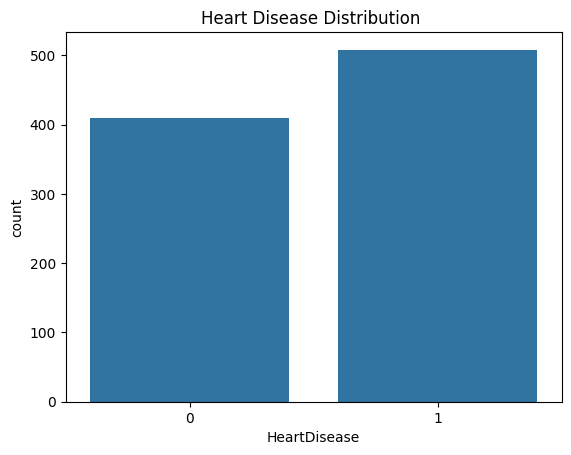

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="HeartDisease",data=df)
plt.title("Heart Disease Distribution ")
plt.show()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

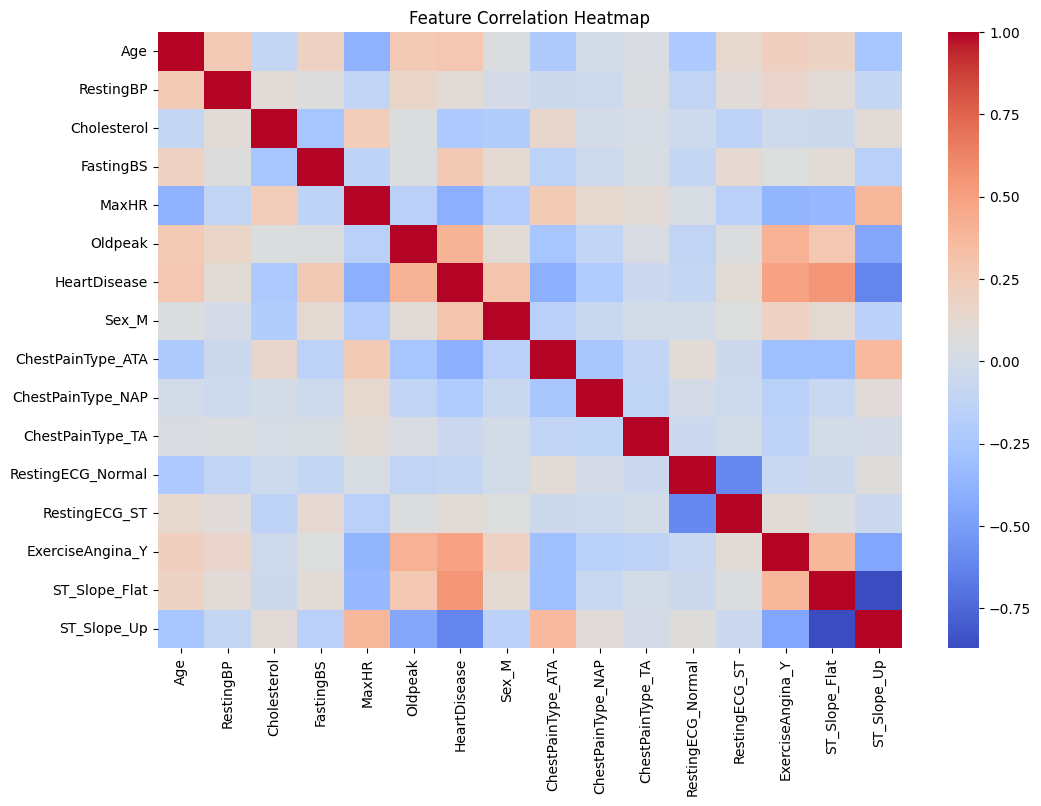

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),cmap='coolwarm',annot=False)
plt.title("Feature Correlation Heatmap")

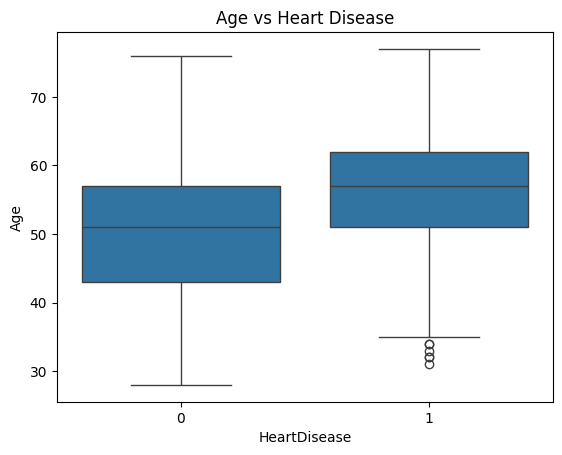

In [7]:
sns.boxplot(x='HeartDisease', y='Age', data=df)
plt.title("Age vs Heart Disease")
plt.show()


In [15]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.8858695652173914
ROC-AUC: 0.9296987087517934
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.8967391304347826
ROC-AUC: 0.9349593495934959
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        82
           1       0.89      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184



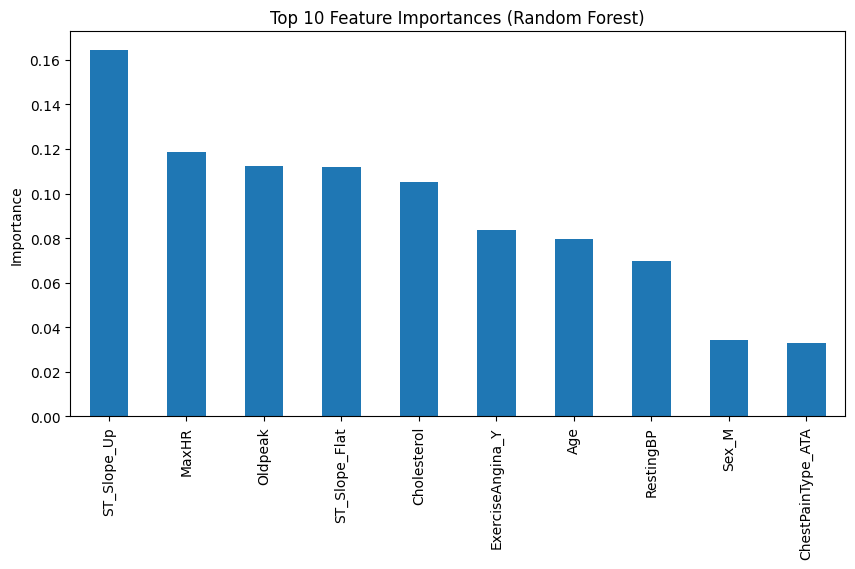

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.show()


In [27]:
import shap

# Use a SMALL sample to avoid shape bugs
X_test_sample = X_test.sample(n=100, random_state=42)

# Create explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values ON THE SAME DATA YOU WILL PLOT
shap_values = explainer.shap_values(X_test_sample)


In [28]:
# Handle different SHAP return formats
if isinstance(shap_values, list):
    shap_vals = shap_values[1]   # class = HeartDisease
else:
    shap_vals = shap_values


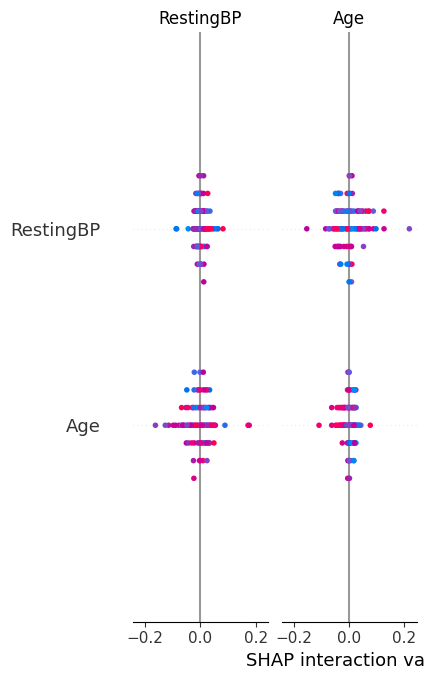

In [29]:
shap.summary_plot(
    shap_vals,
    X_test_sample,
    plot_type="bar",
    show=True
)


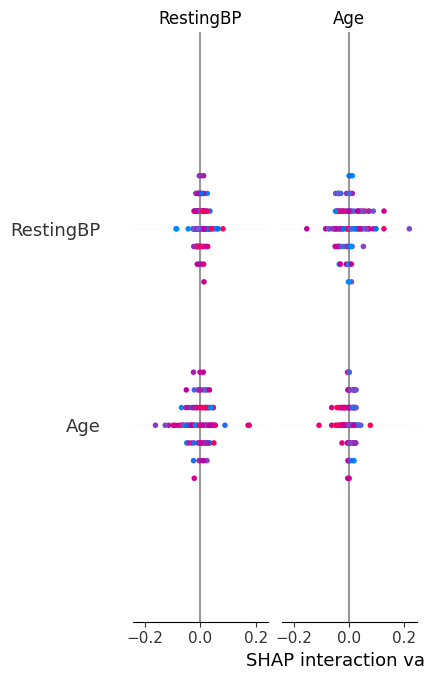

In [30]:
shap.summary_plot(
    shap_vals,
    X_test_sample,
    show=True
)


In [31]:
# Predict probabilities using Random Forest
y_prob_rf = rf.predict_proba(X_test)[:, 1]


In [32]:
def risk_category(prob):
    if prob < 0.30:
        return "Low Risk"
    elif prob < 0.60:
        return "Moderate Risk"
    else:
        return "High Risk"

risk_df = X_test.copy()
risk_df["HeartDisease"] = y_test.values
risk_df["Predicted_Risk"] = y_prob_rf
risk_df["Risk_Group"] = risk_df["Predicted_Risk"].apply(risk_category)

risk_df.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,HeartDisease,Predicted_Risk,Risk_Group
356,46,115,0,0,113,1.5,True,False,False,False,True,False,True,True,False,1,0.956667,High Risk
763,58,132,224,0,173,3.2,True,False,True,False,False,False,False,False,True,1,0.356667,Moderate Risk
817,60,125,258,0,141,2.8,True,False,False,False,False,False,True,True,False,1,0.966667,High Risk
735,49,120,188,0,139,2.0,True,False,True,False,True,False,False,True,False,1,0.616667,High Risk
892,39,138,220,0,152,0.0,False,False,True,False,True,False,False,True,False,0,0.373333,Moderate Risk


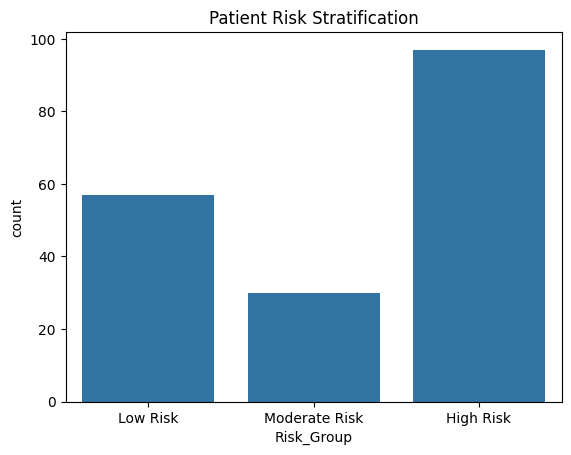

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Risk_Group", data=risk_df, order=["Low Risk", "Moderate Risk", "High Risk"])
plt.title("Patient Risk Stratification")
plt.show()


In [34]:
risk_df.groupby("Risk_Group")[["Age", "Oldpeak", "MaxHR"]].mean()


,Age,Oldpeak,MaxHR
Risk_Group,,,
High Risk,55.556701,1.532990,127.989691
Low Risk,46.508772,0.170175,152.175439
Moderate Risk,51.933333,0.706667,146.700000


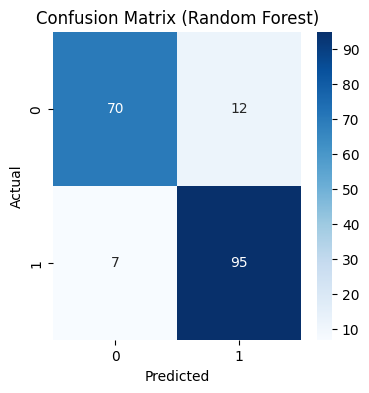

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()


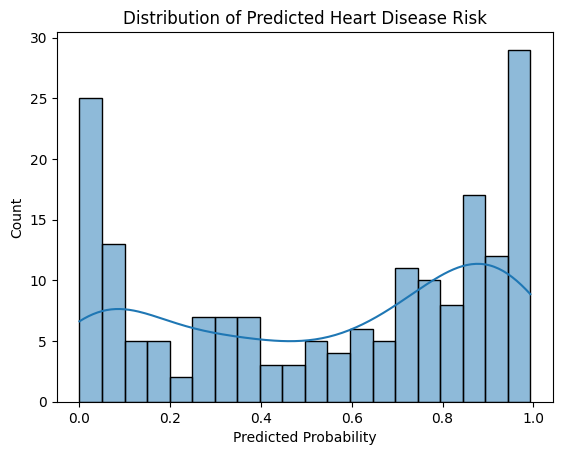

In [36]:
sns.histplot(y_prob_rf, bins=20, kde=True)
plt.title("Distribution of Predicted Heart Disease Risk")
plt.xlabel("Predicted Probability")
plt.show()
